# Analyzing GPT-Neo 125M
After a series of fixes to the pair engine, trying to get a new understanding of what's real.

In [1]:
from collections import OrderedDict
from importlib import reload

import numpy as np
import pandas as pd
from tqdm import tqdm
import graph_tool.all as gt
import matplotlib.pyplot as plt

from gptomics import graph, plot

In [2]:
def read_comps(filename, **kwargs):
    return pd.read_csv(filename, index_col=0, compression="gzip", **kwargs)

In [3]:
def format_axes(ax=None):
    ax = plt.gca() if ax is None else ax

    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["right"].set_linewidth(0)
    ax.spines["top"].set_linewidth(0)

    ax.tick_params(length=5, width=1, which="minor")
    ax.tick_params(length=10, width=1.5, labelsize=18, which="major")

    updates = {"fontname": "Helvetica"}
    xticklabels = ax.get_xticklabels()
    yticklabels = ax.get_yticklabels()
    for l in xticklabels:
        l.update(updates)
    for l in yticklabels:
        l.update(updates)

    xlabel = ax.get_xlabel()
    #ax.set_xlabel(xlabel, fontname="Helvetica")
    ylabel = ax.get_ylabel()
    #ax.set_ylabel(ylabel, fontname="Helvetica")

In [4]:
gptneo125M_orig = read_comps("../data/bad_layernorm/gpt-neo-125M-compositions.csv.gz")
gptneo125M_wd = read_comps("../data/slurm/gpt-neo-125M_compositions.csv.gz")
gptneo125M_od = read_comps("../data/slurm/gpt-neo-125M_compositions_orig.csv.gz")
rev = read_comps("../data/gpt-neo-125M-rev-compositions.csv.gz")

In [5]:
gptneo125M_wd.shape

(37230, 8)

In [6]:
gptneo125M_wd.head()

,src_type,src_block,src_index,dst_type,dst_block,dst_index,term_type,term_value
0,layernorm_bias,0,0,att_head,0,0,Q,0.157901
1,layernorm_bias,0,0,att_head,0,1,Q,0.204128
2,layernorm_bias,0,0,att_head,0,2,Q,0.161927
3,layernorm_bias,0,0,att_head,0,3,Q,0.268744
4,layernorm_bias,0,0,att_head,0,4,Q,0.234157


In [7]:
fulldf = pd.merge(
    gptneo125M_wd,
    gptneo125M_od,
    on=["src_type", "src_block", "src_index", "dst_type", "dst_block", "dst_index", "term_type"],
)

In [8]:
fulldf = fulldf.rename({"term_value_x": "term_value_wiki", "term_value_y": "term_value_orig"}, axis=1)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


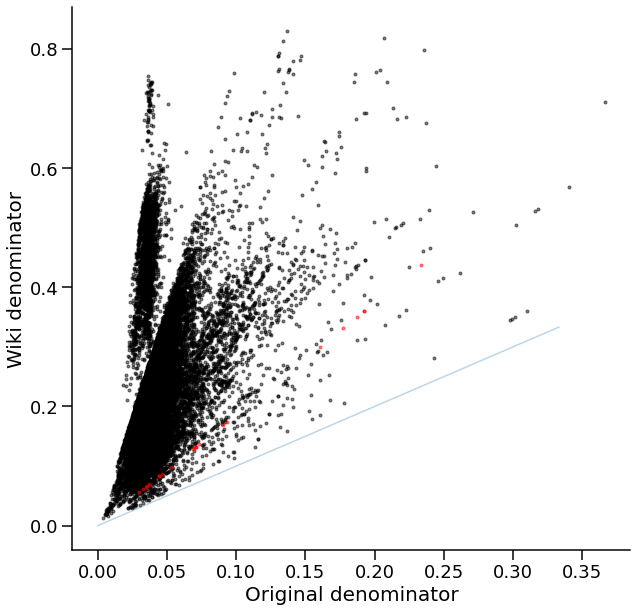

In [9]:
plt.figure(figsize=(10, 10), facecolor="white")

#plotdf = fulldf
#plotdf = fulldf[fulldf.src_type.isin(["layernorm_bias", "mlp_bias", "att_bias"])]
plotdf = fulldf[~((fulldf.dst_type == "att_head")
                  & (fulldf.dst_block == 11)
                  & (fulldf.dst_index == 7)
                  & (fulldf.term_type == "V")
                  & (fulldf.src_type.isin(["mlp_bias", "layernorm_bias", "att_bias"])))]
plotdf2 = fulldf[~fulldf.index.isin(plotdf.index)]

plt.scatter(plotdf.term_value_orig, plotdf.term_value_wiki, marker='.', color='k', alpha=0.5)#, s=2)
plt.scatter(plotdf2.term_value_orig, plotdf2.term_value_wiki, marker='.', color='r', alpha=0.5)#, s=2)

xs = np.arange(1000)/3000
ys = xs# * (0.31/0.27)

plt.plot(xs, ys, alpha=0.3)

plt.xlabel("Original denominator", fontsize=20)
plt.ylabel("Wiki denominator", fontsize=20)
           
format_axes()

plt.show()

* Fusing LN weights with input/output matrices faster to speed things up

* Include MLPs in path analysis
* See if paths functionally maintain signals by injecting noise at an early point, and measuring downstream effects
* Measuring composition with the embedding & unembedding weights
* Look at the maximum value of the reverse edges and see where it pops up
* Functionally analyze the heads that receive many of the top composition weights (particularly V composition)
* Check whether we can find induction heads using our values
* Measure network performance before & after knocking out low composition reads and high composition reads 
* Reserve some portion of the residual stream for embeddings, and then measure how "inflated" the remaining subspaces of the attention head are
* More meta: do a deeper dive into orthogonal vectors, basis, and subspaces

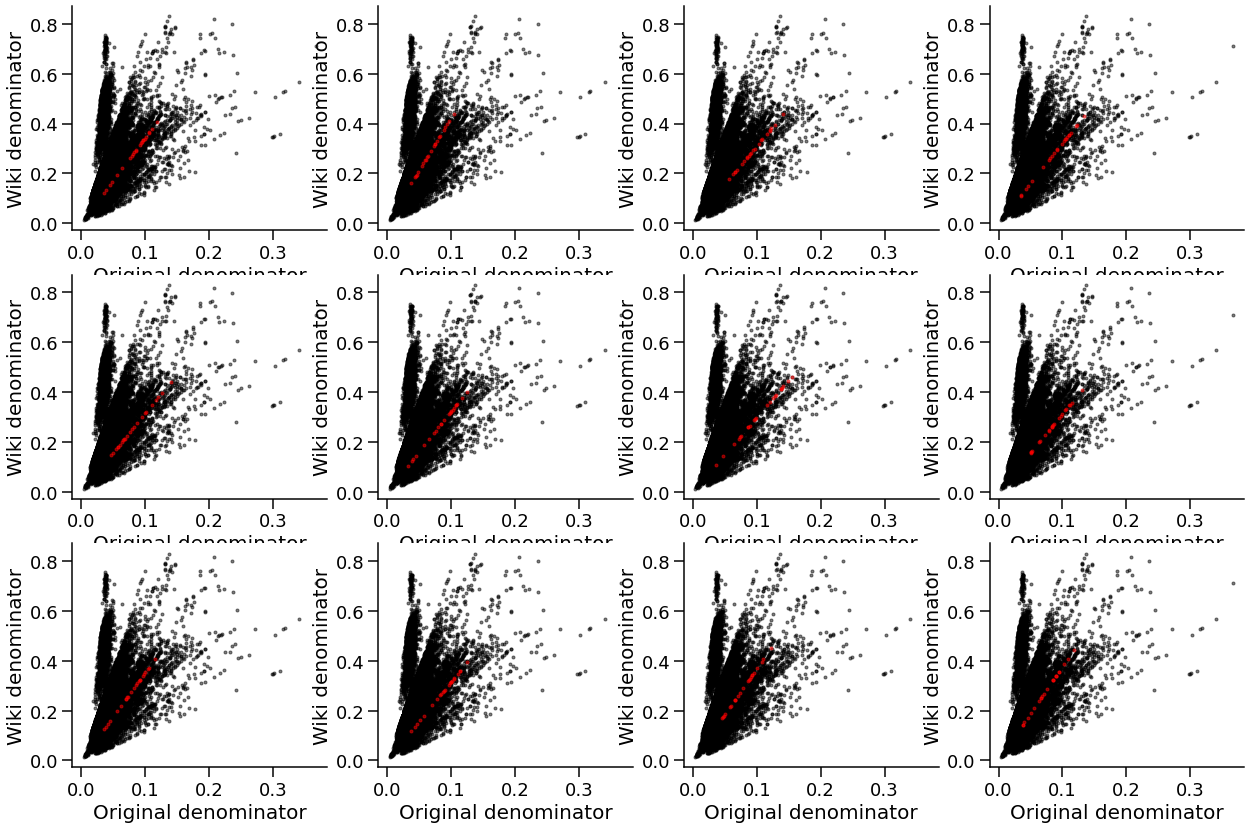

In [10]:
plt.figure(figsize=(21, 14), facecolor="white")

#plotdf = fulldf
#plotdf = fulldf[fulldf.src_type.isin(["layernorm_bias", "mlp_bias", "att_bias"])]
def plots(df, i):
    plotdf = df[~((df.dst_type == "att_head")
                      & (df.dst_block == 11)
                      & (df.dst_index == i)
                      & (df.term_type == "K")
                      & (df.src_type.isin(["mlp_bias", "layernorm_bias", "att_bias"])))]
                      # & (df.src_type.isin(["att_head"])))]
                  
    plotdf2 = df[~df.index.isin(plotdf.index)]

    plt.scatter(plotdf.term_value_orig, plotdf.term_value_wiki, marker='.', color='k', alpha=0.5)#, s=2)
    plt.scatter(plotdf2.term_value_orig, plotdf2.term_value_wiki, marker='.', color='r', alpha=0.5)#, s=2)

    plt.xlabel("Original denominator", fontsize=20)
    plt.ylabel("Wiki denominator", fontsize=20)
           
    format_axes()
    
for i in range(12):
    plt.subplot(3, 4, i+1)
    plots(fulldf, i)

plt.show()

In [11]:
tempdf = fulldf.copy()
tempdf["dist"] = tempdf.term_value_wiki - tempdf.term_value_orig * (0.31/0.27)
tempdf = tempdf.sort_values("dist", ascending=True)

In [12]:
tempdf.head(20)

,src_type,src_block,src_index,dst_type,dst_block,dst_index,term_type,term_value_wiki,term_value_orig,dist
5511,att_bias,0,0,att_head,10,10,V,0.029034,0.025037,0.000287
5583,mlp_bias,0,0,att_head,10,10,V,0.034955,0.030143,0.000346
11111,att_bias,1,0,att_head,10,10,V,0.037691,0.032503,0.000373
16228,mlp_bias,2,0,att_head,10,10,V,0.042185,0.036378,0.000418
11183,mlp_bias,1,0,att_head,10,10,V,0.042773,0.036885,0.000423
20646,att_bias,3,0,att_head,10,10,V,0.050779,0.043789,0.000503
20718,mlp_bias,3,0,att_head,10,10,V,0.052725,0.045468,0.000522
16156,att_bias,2,0,att_head,10,10,V,0.054569,0.047058,0.000540
24581,att_bias,4,0,att_head,10,10,V,0.068327,0.058921,0.000676
24653,mlp_bias,4,0,att_head,10,10,V,0.076391,0.065875,0.000756


In [13]:
dataframes = OrderedDict(
    old_orig_denom=gptneo125M_orig,
    new_denom=gptneo125M_wd,
    orig_denom=gptneo125M_od,
)

In [14]:
def basic_value_plot(df, bounds=False):
    plt.hist(df.term_value, bins=50, color='k')
    plt.axvline(df.term_value.max(), ls='--', color='r')
    plt.axvline(np.percentile(df.term_value.tolist(), 50), ls='--', color='b')
    plt.axvline(np.percentile(df.term_value.tolist(), 95), ls='--', color='g')
    
    if bounds:
        plt.xlim(0, 1)
    
    plt.xlabel("Composition term value", fontsize=20)
    plt.ylabel("Count", fontsize=20)
    
    format_axes()

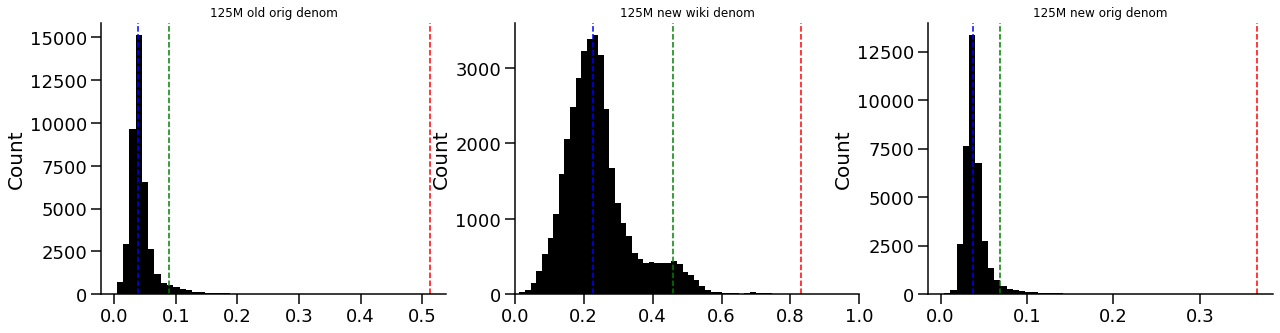

In [15]:
plt.figure(figsize=(21, 5), facecolor="white")

plt.subplot(1, 3, 1)
basic_value_plot(gptneo125M_orig)
plt.title("125M old orig denom")
plt.xlabel("")
#plt.xlim(0, 1)

plt.subplot(1, 3, 2)
basic_value_plot(gptneo125M_wd)
plt.title("125M new wiki denom")
plt.xlabel("")
plt.xlim(0, 1)

plt.subplot(1, 3, 3)
basic_value_plot(gptneo125M_od)
plt.title("125M new orig denom")
plt.xlabel("")
#plt.xlim(0, 1)

plt.show()

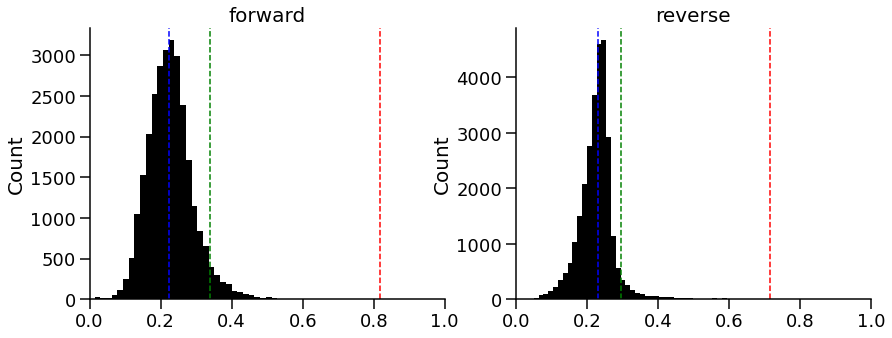

In [16]:
plt.figure(figsize=(14, 5), facecolor="white")

plt.subplot(1, 2, 1)
basic_value_plot(gptneo125M_wd[(gptneo125M_wd.src_type == "att_head")
                               & (gptneo125M_wd.dst_type == "att_head")])
plt.title("forward", fontsize=20)
plt.xlabel("")
plt.xlim(0, 1)

plt.subplot(1, 2, 2)
basic_value_plot(rev[(rev.src_type == "att_head")
                     & (rev.dst_type == "att_head")])
plt.title("reverse", fontsize=20)
plt.xlabel("")
plt.xlim(0, 1)

plt.show()

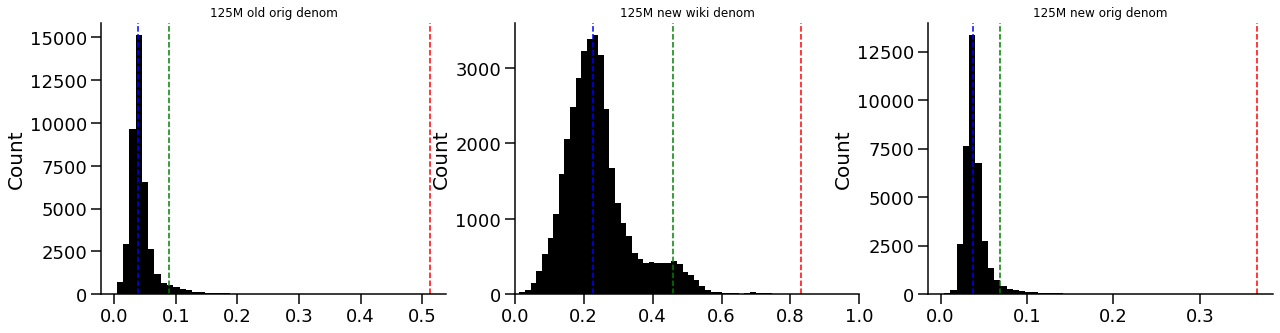

In [17]:
plt.figure(figsize=(21, 5), facecolor="white")

plt.subplot(1, 3, 1)
basic_value_plot(gptneo125M_orig)
plt.title("125M old orig denom")
plt.xlabel("")
#plt.xlim(0, 1)

plt.subplot(1, 3, 2)
basic_value_plot(gptneo125M_wd)
plt.title("125M new wiki denom")
plt.xlabel("")
plt.xlim(0, 1)

plt.subplot(1, 3, 3)
basic_value_plot(gptneo125M_od)
plt.title("125M new orig denom")
plt.xlabel("")
#plt.xlim(0, 1)

plt.show()

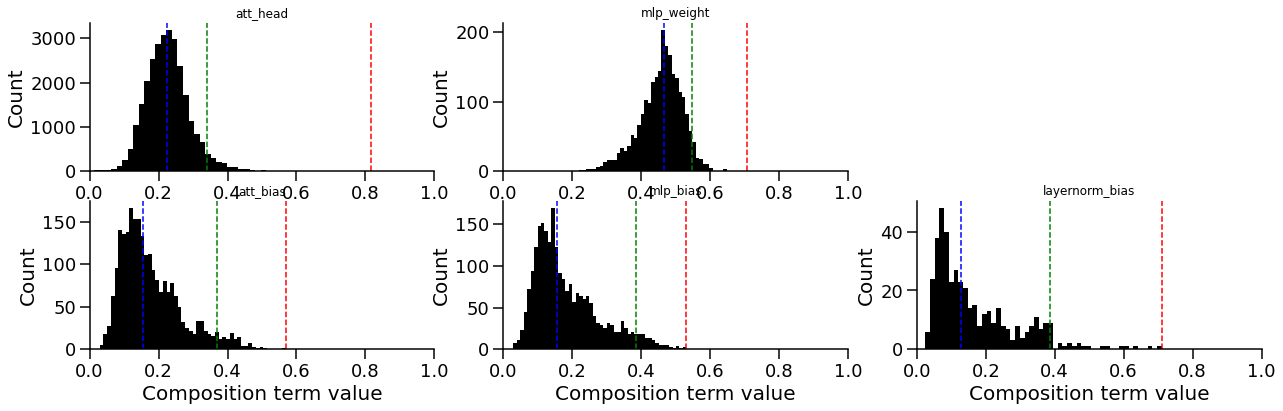

In [18]:
plt.figure(figsize=(21, 6), facecolor="white")

sources = ["att_head", "mlp_weight", "att_bias", "mlp_bias", "layernorm_bias"]
for i, src in enumerate(sources):
    j = i + 1 if i < 2 else i + 2  # skipping plot #3
    plt.subplot(2, 3, j)
    basic_value_plot(
        gptneo125M_wd[
            (gptneo125M_wd.src_type == src)
            & (gptneo125M_wd.dst_type == "att_head")
        ]
    )
    plt.title(src)
    if i < 2:
        plt.xlabel("")
    plt.xlim(0, 1)

plt.show()

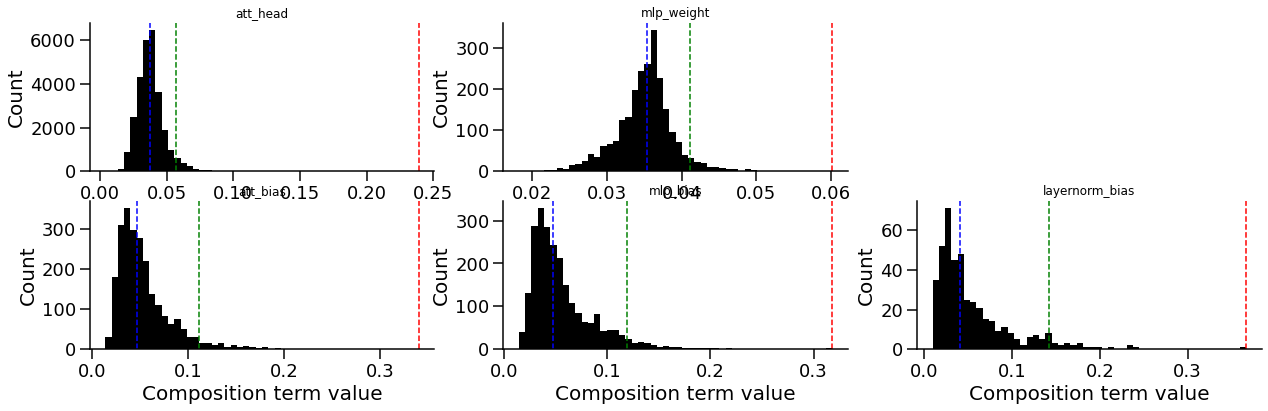

In [19]:
plt.figure(figsize=(21, 6), facecolor="white")

sources = ["att_head", "mlp_weight", "att_bias", "mlp_bias", "layernorm_bias"]
for i, src in enumerate(sources):
    j = i + 1 if i < 2 else i + 2  # skipping plot #3
    plt.subplot(2, 3, j)
    basic_value_plot(
        gptneo125M_od[
            (gptneo125M_od.src_type == src)
            & (gptneo125M_od.dst_type == "att_head")
        ]
    )
    plt.title(src)
    if i < 2:
        plt.xlabel("")
    #plt.xlim(0, 1)

plt.show()

In [20]:
colors = ["#171219", "#DA3E52", "#2E86AB", "#F18F01", "#531CB3"]

In [21]:
def percentiles_by_type(
    df,
    type_colname="term_type",
    src_types=["att_head"],
    dst_types=["att_head"],
    types=["Q", "K", "V"],
):
    subdf = df[(df.src_type.isin(src_types))
               & (df.dst_type == "att_head")]
    
    return plot.percentiles_by_type(
        subdf, type_colname, types=types, colors=colors
    )

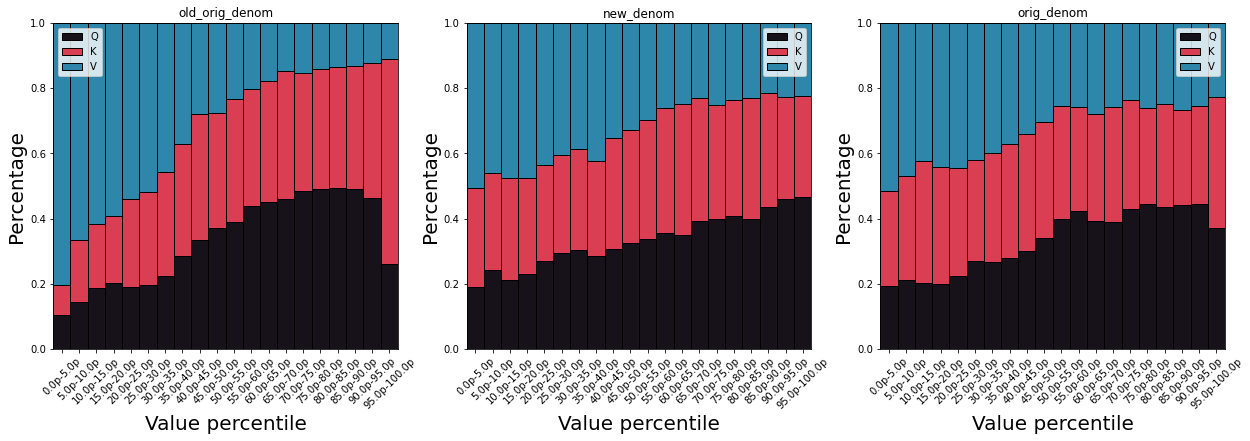

In [22]:
plt.figure(figsize=(21, 6), facecolor="white")

for (i, (name, df)) in enumerate(dataframes.items()):
    plt.subplot(1, 3, i+1)
    percentiles_by_type(df)
    plt.title(name)
    
plt.show()

In [23]:
attonly = gptneo125M_wd[
    (gptneo125M_wd.src_type == "att_head")
    & (gptneo125M_wd.dst_type == "att_head")
]

In [24]:
attonly_od = gptneo125M_od[
    (gptneo125M_od.src_type == "att_head")
    & (gptneo125M_od.dst_type == "att_head")
]

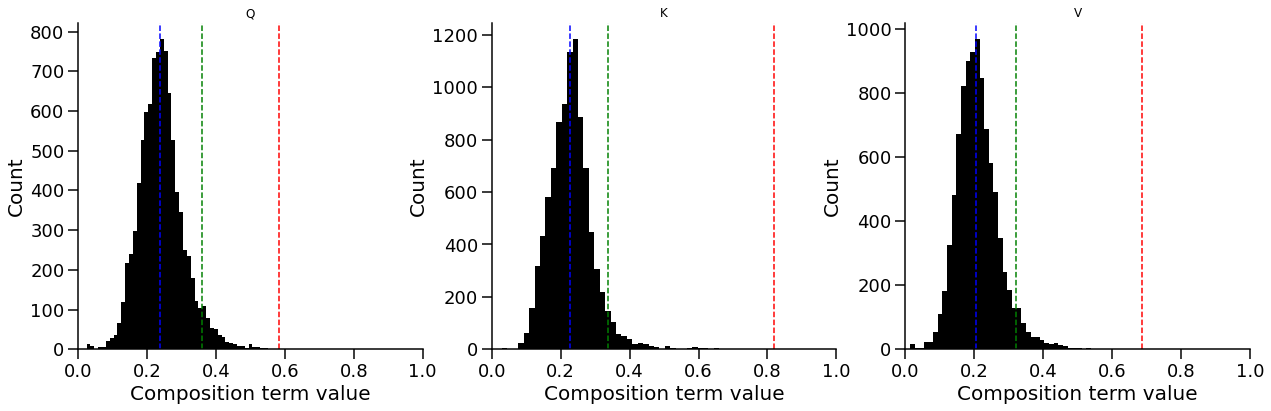

In [25]:
plt.figure(figsize=(21, 6), facecolor="white")

for i, term_type in enumerate(["Q", "K", "V"]):
    plt.subplot(1, 3, i+1)
    basic_value_plot(attonly[attonly.term_type == term_type])
    plt.title(term_type)
    plt.xlim(0, 1)

plt.show()

In [26]:
avg_vals = attonly.groupby(["dst_block", "dst_index", "term_type"]).mean()["term_value"].reset_index()

In [27]:
top1p = attonly[attonly.term_value >= np.percentile(attonly.term_value, 99)]
top5p = attonly[attonly.term_value >= np.percentile(attonly.term_value, 95)]

In [28]:
top1p_od = attonly_od[attonly_od.term_value >= np.percentile(attonly_od.term_value, 99)]
top5p_od = attonly_od[attonly_od.term_value >= np.percentile(attonly_od.term_value, 95)]

In [29]:
def plot_count_by_head(df):
    num_received = np.zeros((12, 12), dtype=np.uint8)
    for i, j in zip(df.dst_block, df.dst_index):
        num_received[i, j] += 1

    plt.imshow(num_received.T)
    plt.xlabel("block", fontsize=20)
    plt.ylabel("attention head", fontsize=20)

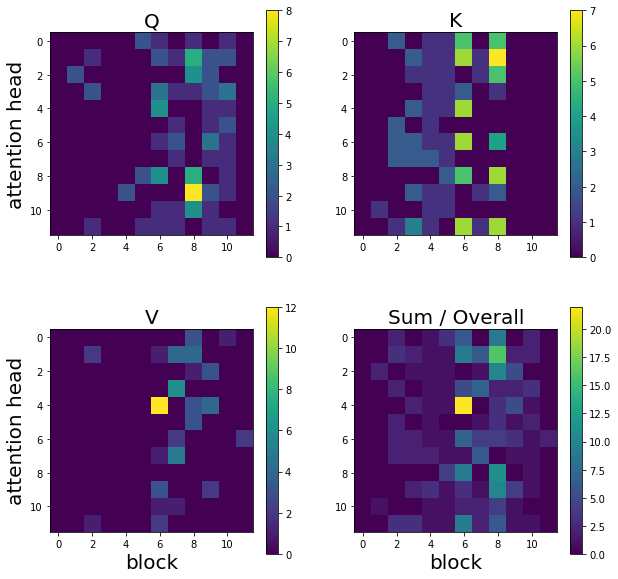

In [30]:
plt.figure(figsize=(10, 10), facecolor="white")

plt.subplot(2, 2, 1)
plot_count_by_head(top1p[top1p.term_type == "Q"])
plt.colorbar()
plt.title("Q", fontsize=20)
plt.xlabel("")

plt.subplot(2, 2, 2)
plot_count_by_head(top1p[top1p.term_type == "K"])
plt.colorbar()
plt.title("K", fontsize=20)
plt.xlabel("")
plt.ylabel("")

plt.subplot(2, 2, 3)
plot_count_by_head(top1p[top1p.term_type == "V"])
plt.colorbar()
plt.title("V", fontsize=20)

plt.subplot(2, 2, 4)
plot_count_by_head(top1p)
plt.colorbar()#ticks=[0, 5, 10, 15, 20, 22])
plt.title("Sum / Overall", fontsize=20)
plt.ylabel("")

#plt.suptitle("top 1%", fontsize=20)

plt.show()

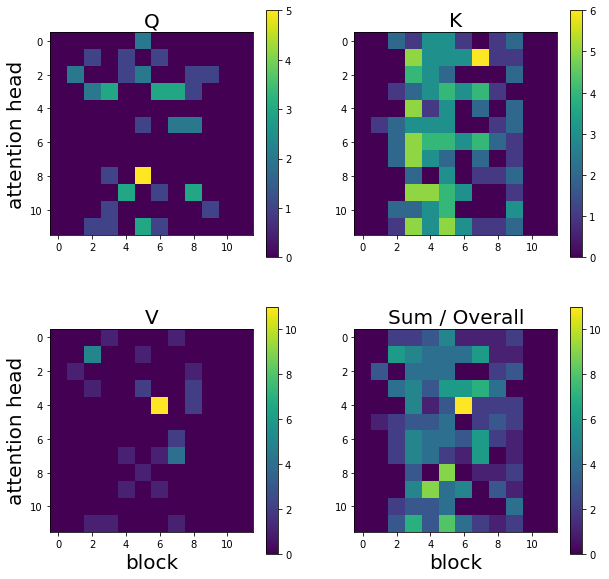

In [31]:
plt.figure(figsize=(10, 10), facecolor="white")

plt.subplot(2, 2, 1)
plot_count_by_head(top1p_od[top1p_od.term_type == "Q"])
plt.colorbar()
plt.title("Q", fontsize=20)
plt.xlabel("")

plt.subplot(2, 2, 2)
plot_count_by_head(top1p_od[top1p_od.term_type == "K"])
plt.colorbar()
plt.title("K", fontsize=20)
plt.xlabel("")
plt.ylabel("")

plt.subplot(2, 2, 3)
plot_count_by_head(top1p_od[top1p_od.term_type == "V"])
plt.colorbar()
plt.title("V", fontsize=20)

plt.subplot(2, 2, 4)
plot_count_by_head(top1p_od)
plt.colorbar()#ticks=[0, 5, 10, 15, 20, 22])
plt.title("Sum / Overall", fontsize=20)
plt.ylabel("")

#plt.suptitle("top 1%", fontsize=20)

plt.show()

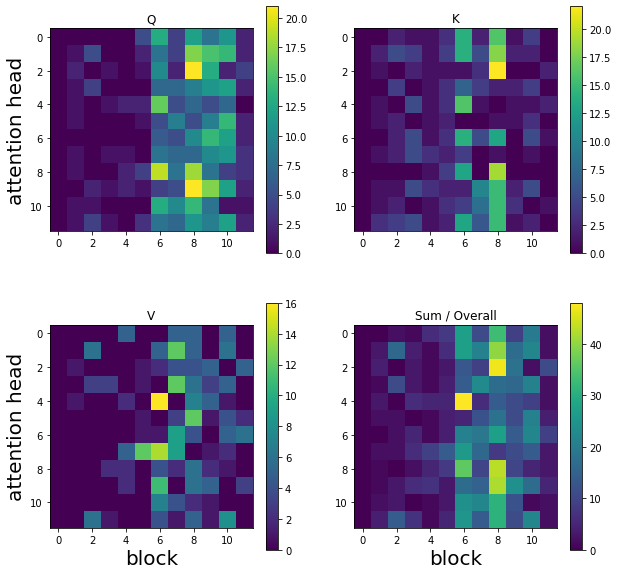

In [32]:
plt.figure(figsize=(10, 10), facecolor="white")

plt.subplot(2, 2, 1)
plot_count_by_head(top5p[top5p.term_type == "Q"])
plt.colorbar()
plt.title("Q")
plt.xlabel("")

plt.subplot(2, 2, 2)
plot_count_by_head(top5p[top5p.term_type == "K"])
plt.colorbar()
plt.title("K")
plt.xlabel("")
plt.ylabel("")

plt.subplot(2, 2, 3)
plot_count_by_head(top5p[top5p.term_type == "V"])
plt.colorbar()
plt.title("V")

plt.subplot(2, 2, 4)
plot_count_by_head(top5p)
plt.colorbar()
plt.title("Sum / Overall")
plt.ylabel("")

plt.show()

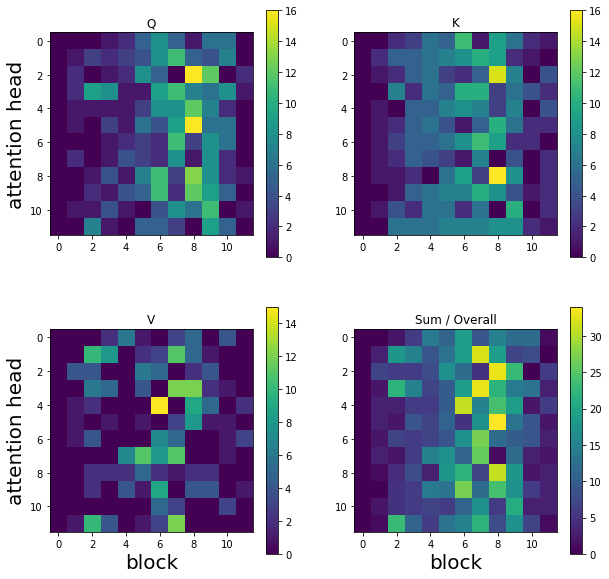

In [33]:
plt.figure(figsize=(10, 10), facecolor="white")

plt.subplot(2, 2, 1)
plot_count_by_head(top5p_od[top5p_od.term_type == "Q"])
plt.colorbar()
plt.title("Q")
plt.xlabel("")

plt.subplot(2, 2, 2)
plot_count_by_head(top5p_od[top5p_od.term_type == "K"])
plt.colorbar()
plt.title("K")
plt.xlabel("")
plt.ylabel("")

plt.subplot(2, 2, 3)
plot_count_by_head(top5p_od[top5p_od.term_type == "V"])
plt.colorbar()
plt.title("V")

plt.subplot(2, 2, 4)
plot_count_by_head(top5p_od)
plt.colorbar()
plt.title("Sum / Overall")
plt.ylabel("")

plt.show()

In [34]:
def plot_top_p_block_dists(df, src_types):
    df = df.copy()
    df["1p_grp"] = plot.compute_percentile_bins(df, nbins=100)
    
    subdf = df[(df["1p_grp"] == 100)
               & (df.src_type.isin(src_types))]
    
    diffs = subdf.dst_block - subdf.src_block
    max_block = df.dst_block.max() + 1
    plt.hist(
        diffs,
        bins=np.arange(-1, max_block),
        color="k"
    )
    
    plt.xlabel("Block distance", fontsize=20)
    plt.ylabel("Count", fontsize=20)
    plt.xlim(0, max_block)

In [35]:
def plot_top_p_block_dist_types(df):
    
    def plot_type(typename):
        plot_top_p_block_dists(df, [typename])
        plt.title(typename)
    
    plt.subplot(2, 2, 1)
    plot_type("att_head")
    plt.xlabel("")
    
    plt.subplot(2, 2, 2)
    plot_type("att_bias")
    plt.xlabel("")
    plt.ylabel("")
    
    plt.subplot(2, 2, 3)
    plot_type("mlp_weight")
    
    plt.subplot(2, 2, 4)
    plot_type("mlp_bias")
    plt.ylabel("")

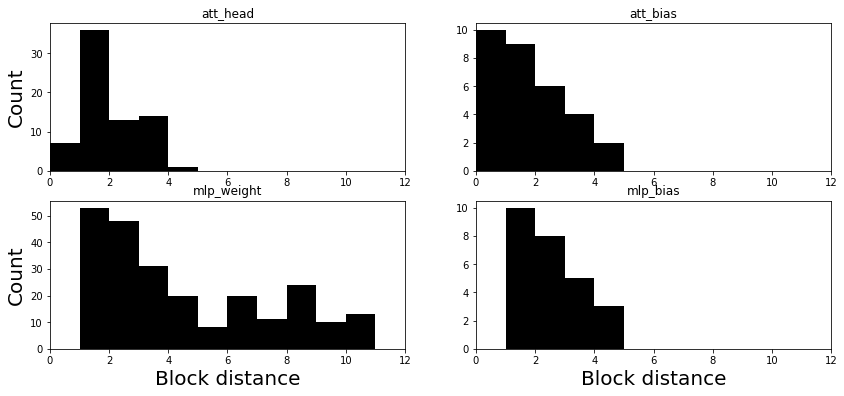

In [36]:
plt.figure(figsize=(14, 6))

plot_top_p_block_dist_types(gptneo125M_wd)

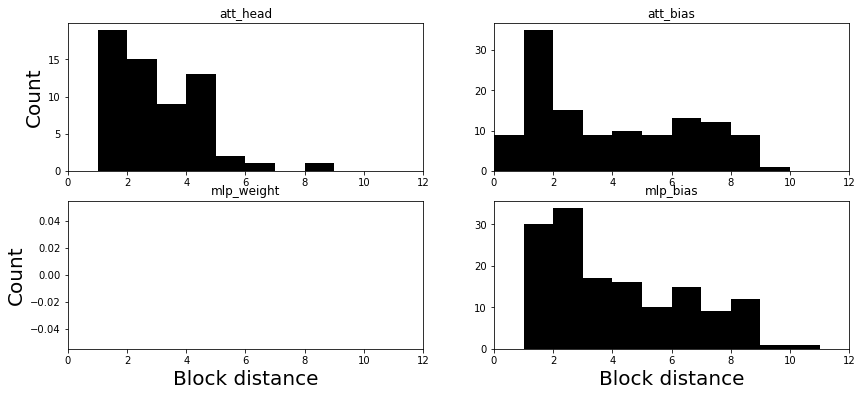

In [37]:
plt.figure(figsize=(14, 6))

plot_top_p_block_dist_types(gptneo125M_od)

# Graph analysis

In [38]:
%%time
g = graph.pair_term_graph(attonly)

CPU times: user 736 ms, sys: 70 µs, total: 736 ms
Wall time: 736 ms


In [39]:
%%time
g_od = graph.pair_term_graph(attonly_od)

CPU times: user 698 ms, sys: 60 µs, total: 698 ms
Wall time: 697 ms


In [40]:
g.vertex_properties["block"].a.max()

PropertyArray(11, dtype=int32)

In [41]:
def ipc_plot(gs, percs, vertex_mask):
    percs = graph.ipc_percentiles(gs, percs, vertex_mask)
    
    plot.plot_ipc_percentiles(percs)

    
def ipc_analysis(g, xmin=70):
    num_blocks = int(g.vertex_properties["block"].a.max()) + 1
    percs = [0, 25, 50, 75, 100]
    
    plt.subplot(2, 3, 1)
    ipc_plot(graph.value_perc_thresholds(g), percs, None)
    plt.title("All vertices", fontsize=20)
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 4)
    ipc_plot(graph.random_removal(g), percs, None)
    plt.xlabel("Random edge removal")
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 2)
    ipc_plot(
        graph.value_perc_thresholds(g),
        percs,
        g.vertex_properties["block"].a >= num_blocks // 2,
    )
    plt.title("Second half", fontsize=20)
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 5)
    ipc_plot(
        graph.random_removal(g),
        percs,
        g.vertex_properties["block"].a >= num_blocks // 2,
    )
    plt.xlabel("Random edge removal")
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 3)
    ipc_plot(
        graph.value_perc_thresholds(g),
        percs,
        g.vertex_properties["block"].a >= (num_blocks // 4) * 3
    )
    plt.title("Last quarter", fontsize=20)
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 6)
    ipc_plot(
        graph.random_removal(g),
        percs,
        g.vertex_properties["block"].a >= (num_blocks // 4) * 3
    )
    plt.xlabel("Random edge removal")
    if xmin is not None:
        plt.xlim(xmin, 100)


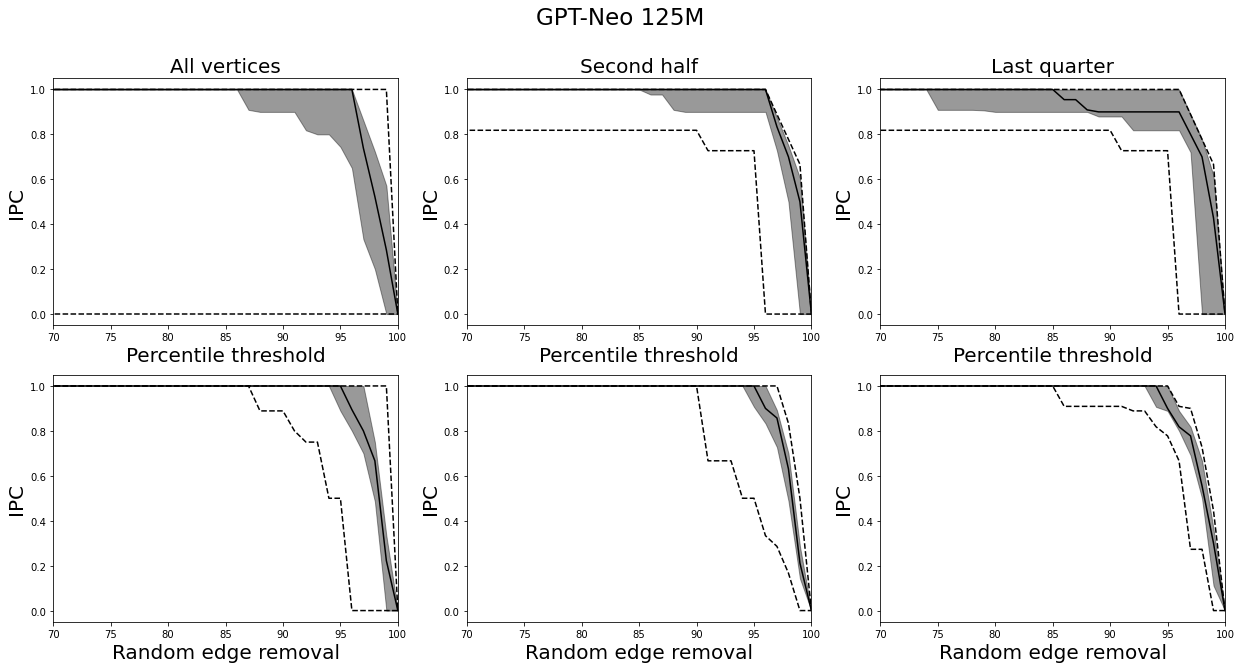

In [42]:
plt.figure(figsize=(21, 10))
ipc_analysis(g)
plt.suptitle("GPT-Neo 125M", fontsize=23)
plt.show()

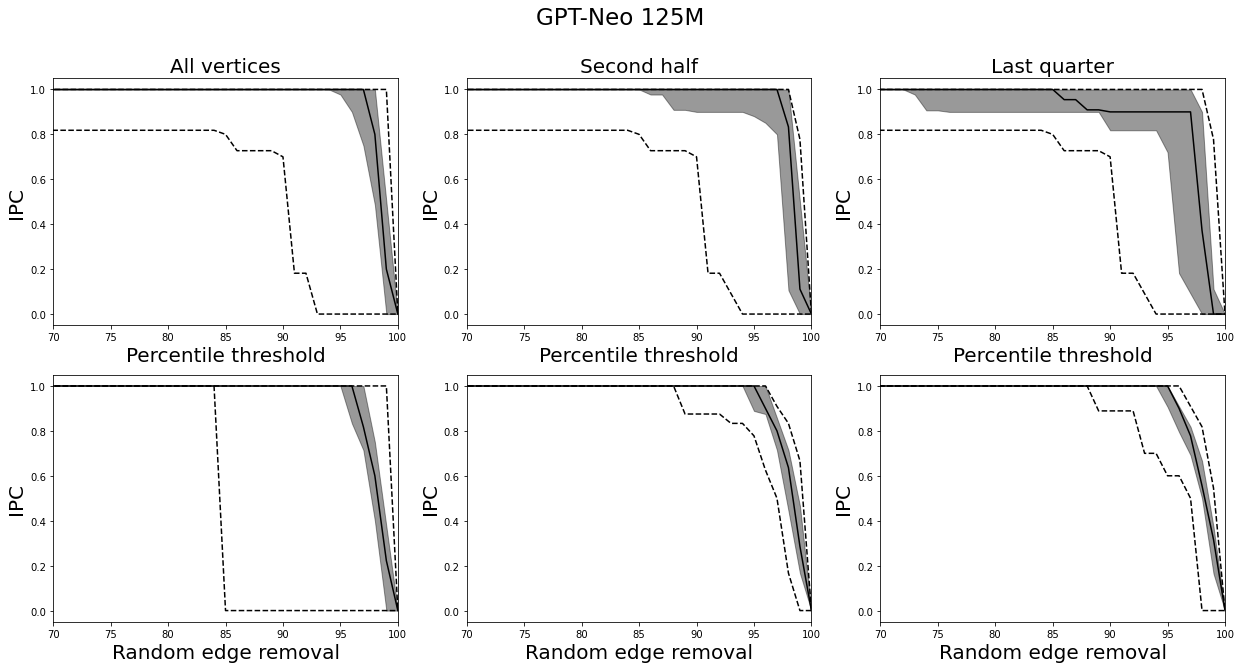

In [43]:
plt.figure(figsize=(21, 10))
ipc_analysis(g_od)
plt.suptitle("GPT-Neo 125M", fontsize=23)
plt.show()

In [44]:
def random99p(g: gt.Graph) -> gt.Graph:
    """Randomly removes 99% of the edges."""
    perm = np.random.permutation(np.arange(len(g.get_edges())))
    mask = np.ones((len(perm),), dtype=bool)
    
    numedges = int(np.ceil(len(perm) / 100)) * 99
    inds = perm[:numedges]
    mask[inds] = False
    graph.filter_edges_by_arr(g, mask)
    
    return g

In [45]:
ipcs = list()
for i in tqdm(range(1000)):
    g.set_edge_filter(None)
    rand = random99p(g)
    ipcs.append(graph.input_path_complexities(rand))

ipcs = np.array(ipcs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 808.25it/s]


In [46]:
bins = np.array([0.05 * i for i in range(21)])
hists = np.array([np.histogram(row, bins=bins)[0] for row in ipcs])

p2p5 = np.array([np.percentile(hists[:, i], 2.5) for i in range(20)])
p97p5 = np.array([np.percentile(hists[:, i], 97.5) for i in range(20)])

In [47]:
value_thresh = np.percentile(g.edge_properties["term_value"].a, 99)
g.set_edge_filter(None)
graph.threshold_value(g, value_thresh)
graph.threshold_value(g_od, np.percentile(g_od.edge_properties["term_value"].a, 99))

orig_ipcs = graph.input_path_complexities(g)
orig_ipcs_od = graph.input_path_complexities(g_od)

In [48]:
def plot_comparison(vertex_mask, orig=orig_ipcs, randoms=ipcs):
    orig_ipcs_masked = orig[vertex_mask]
    hists_masked = np.array([np.histogram(row[vertex_mask], bins=bins)[0] for row in randoms])
        
    p2p5 = np.array([np.percentile(hists_masked[:, i], 2.5) for i in range(20)])
    p50 = np.array([np.percentile(hists_masked[:, i], 50) for i in range(20)])
    p97p5 = np.array([np.percentile(hists_masked[:, i], 97.5) for i in range(20)])    
    
    plt.hist(orig_ipcs_masked, bins=bins, edgecolor='k', histtype="step", lw=2)
    plt.xlabel("IPC", fontsize=20)
    plt.ylabel("Count", fontsize=20)

    xs = (bins[:-1] + bins[1:]) / 2
    plt.plot(xs, p50, color='#A29C9B')
    plt.fill_between(xs, p2p5, p97p5, alpha=0.5, color='#A29C9B')
    
    format_axes()

In [49]:
bins = np.array([0.05 * i for i in range(21)])

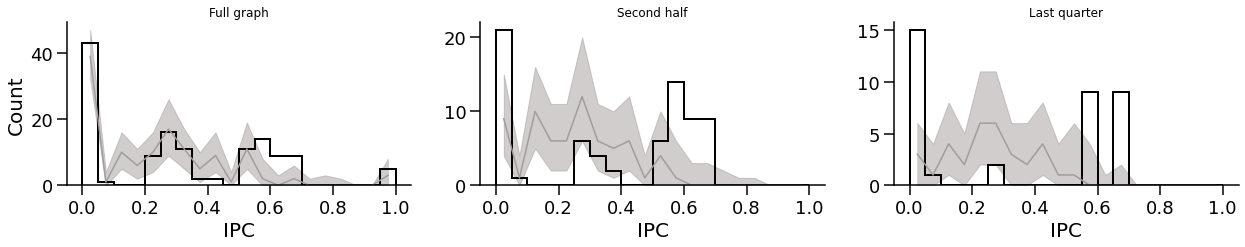

In [50]:
plt.figure(figsize=(21, 3), facecolor="white")

numblocks = g.vertex_properties["block"].a.max() + 1

plt.subplot(1, 3, 1)
plot_comparison(np.ones((len(g.vertex_properties["block"].a),), dtype=bool))
plt.title("Full graph")

plt.subplot(1, 3, 2)
plot_comparison(g.vertex_properties["block"].a >= numblocks / 2)
plt.title("Second half")
plt.ylabel("")

plt.subplot(1, 3, 3)
plot_comparison(g.vertex_properties["block"].a >= numblocks * 3 / 4)
plt.title("Last quarter")
plt.ylabel("")

plt.show()

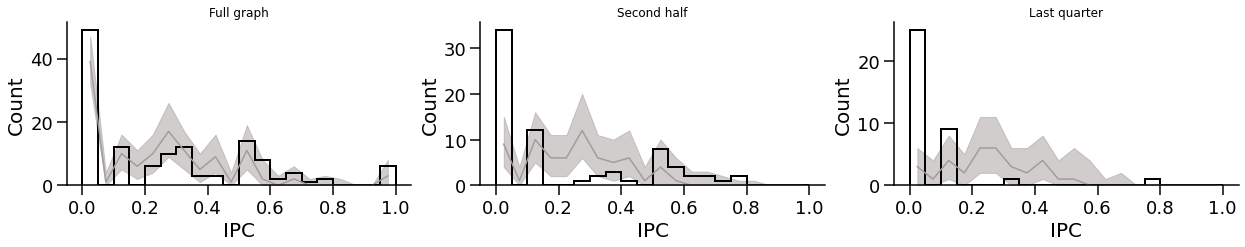

In [52]:
plt.figure(figsize=(21, 3), facecolor="white")

numblocks = g.vertex_properties["block"].a.max() + 1

plt.subplot(1, 3, 1)
plot_comparison(np.ones((len(g.vertex_properties["block"].a),), dtype=bool), orig_ipcs_od)
plt.title("Full graph")

plt.subplot(1, 3, 2)
plot_comparison(g.vertex_properties["block"].a >= numblocks / 2, orig_ipcs_od)
plt.title("Second half")

plt.subplot(1, 3, 3)
plot_comparison(g.vertex_properties["block"].a >= numblocks * 3 / 4, orig_ipcs_od)
plt.title("Last quarter")

plt.show()

# Graph analysis w/ MLPs & LNs

In [53]:
%%time
g = graph.pair_term_graph(gptneo125M_wd)

CPU times: user 993 ms, sys: 0 ns, total: 993 ms
Wall time: 994 ms


In [54]:
%%time
g_od = graph.pair_term_graph(gptneo125M_od)

CPU times: user 888 ms, sys: 7.89 ms, total: 896 ms
Wall time: 895 ms


In [55]:
g.vertex_properties["block"].a.max()

PropertyArray(11, dtype=int32)

In [56]:
def ipc_plot(gs, percs, vertex_mask, ceil):
    percs = graph.ipc_percentiles(gs, percs, vertex_mask, ceil)
    
    plot.plot_ipc_percentiles(percs)

    
def ipc_analysis(g, ceil, xmin=70):
    num_blocks = int(g.vertex_properties["block"].a.max()) + 1
    percs = [0, 25, 50, 75, 100]
    
    plt.subplot(2, 3, 1)
    ipc_plot(graph.value_perc_thresholds(g), percs, None, ceil)
    plt.title("All vertices", fontsize=20)
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 4)
    ipc_plot(graph.random_removal(g), percs, None, ceil)
    plt.xlabel("Random edge removal")
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 2)
    ipc_plot(
        graph.value_perc_thresholds(g),
        percs,
        g.vertex_properties["block"].a >= num_blocks // 2,
        ceil,
    )
    plt.title("Second half", fontsize=20)
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 5)
    ipc_plot(
        graph.random_removal(g),
        percs,
        g.vertex_properties["block"].a >= num_blocks // 2,
        ceil,
    )
    plt.xlabel("Random edge removal")
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 3)
    ipc_plot(
        graph.value_perc_thresholds(g),
        percs,
        g.vertex_properties["block"].a >= (num_blocks // 4) * 3,
        ceil,
    )
    plt.title("Last quarter", fontsize=20)
    if xmin is not None:
        plt.xlim(xmin, 100)
    
    plt.subplot(2, 3, 6)
    ipc_plot(
        graph.random_removal(g),
        percs,
        g.vertex_properties["block"].a >= (num_blocks // 4) * 3,
        ceil,
    )
    plt.xlabel("Random edge removal")
    if xmin is not None:
        plt.xlim(xmin, 100)


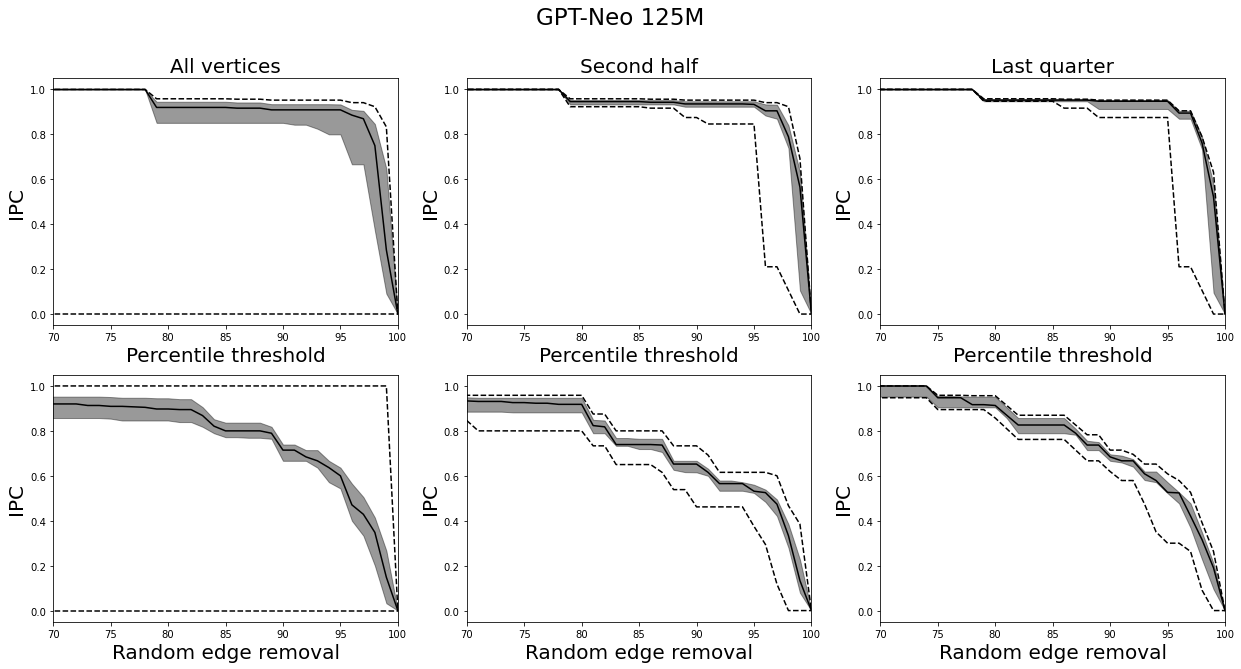

In [59]:
plt.figure(figsize=(21, 10))
ipc_analysis(g, graph.gptneo_ceil(g))
plt.suptitle("GPT-Neo 125M", fontsize=23)
plt.show()

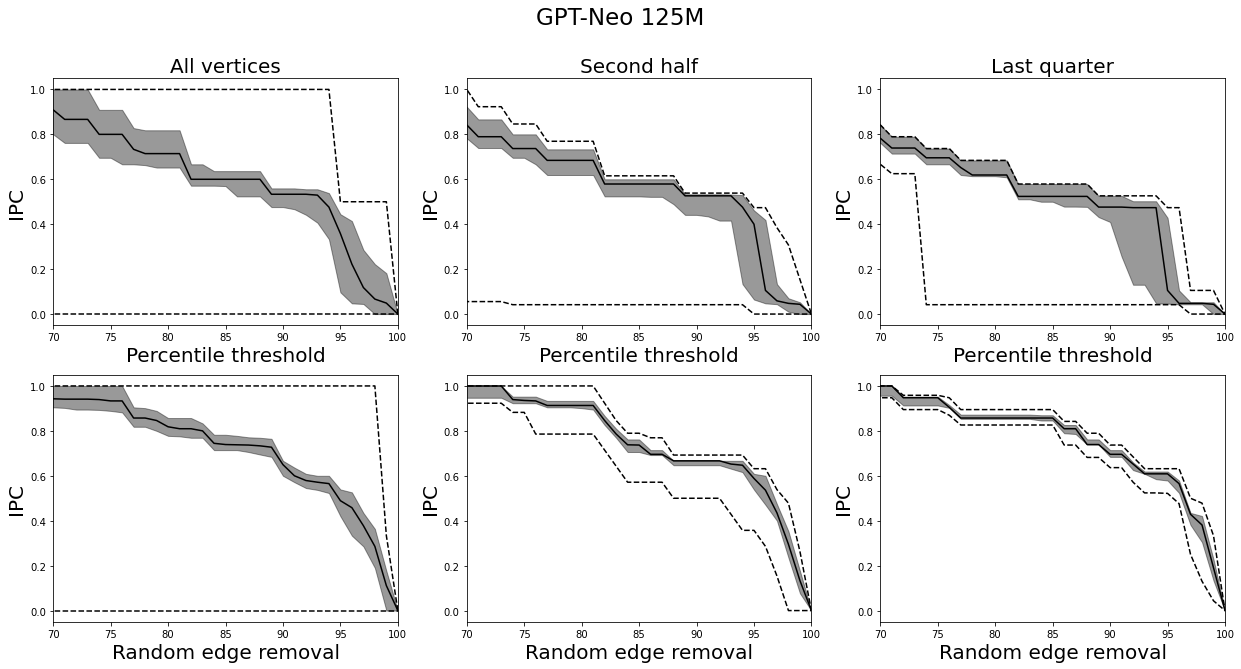

In [61]:
plt.figure(figsize=(21, 10))
ipc_analysis(g_od, graph.gptneo_ceil(g_od))
plt.suptitle("GPT-Neo 125M", fontsize=23)
plt.show()

In [63]:
def random99p(g: gt.Graph) -> gt.Graph:
    """Randomly removes 99% of the edges."""
    perm = np.random.permutation(np.arange(len(g.get_edges())))
    mask = np.ones((len(perm),), dtype=bool)
    
    numedges = int(np.ceil(len(perm) / 100)) * 99
    inds = perm[:numedges]
    mask[inds] = False
    graph.filter_edges_by_arr(g, mask)
    
    return g

In [64]:
ipcs = list()
ceil = graph.gptneo_ceil(g)
for i in tqdm(range(1000)):
    g.set_edge_filter(None)
    rand = random99p(g)
    ipcs.append(graph.input_path_complexities(rand, ceil))

ipcs = np.array(ipcs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 603.72it/s]


In [65]:
bins = np.array([0.05 * i for i in range(21)])
hists = np.array([np.histogram(row, bins=bins)[0] for row in ipcs])

p2p5 = np.array([np.percentile(hists[:, i], 2.5) for i in range(20)])
p97p5 = np.array([np.percentile(hists[:, i], 97.5) for i in range(20)])

In [66]:
value_thresh = np.percentile(g.edge_properties["term_value"].a, 99)
g.set_edge_filter(None)
graph.threshold_value(g, value_thresh)
graph.threshold_value(g_od, np.percentile(g_od.edge_properties["term_value"].a, 99))

orig_ipcs = graph.input_path_complexities(g, ceil)
orig_ipcs_od = graph.input_path_complexities(g_od, ceil)

In [67]:
def plot_comparison(vertex_mask, orig=orig_ipcs, randoms=ipcs):
    orig_ipcs_masked = orig[vertex_mask]
    hists_masked = np.array([np.histogram(row[vertex_mask], bins=bins)[0] for row in randoms])
        
    p2p5 = np.array([np.percentile(hists_masked[:, i], 2.5) for i in range(20)])
    p50 = np.array([np.percentile(hists_masked[:, i], 50) for i in range(20)])
    p97p5 = np.array([np.percentile(hists_masked[:, i], 97.5) for i in range(20)])    
    
    plt.hist(orig_ipcs_masked, bins=bins, edgecolor='k', histtype="step", lw=2)
    plt.xlabel("IPC", fontsize=20)
    plt.ylabel("Count", fontsize=20)

    xs = (bins[:-1] + bins[1:]) / 2
    plt.plot(xs, p50, color='#A29C9B')
    plt.fill_between(xs, p2p5, p97p5, alpha=0.5, color='#A29C9B')
    
    format_axes()

In [68]:
bins = np.array([0.05 * i for i in range(21)])

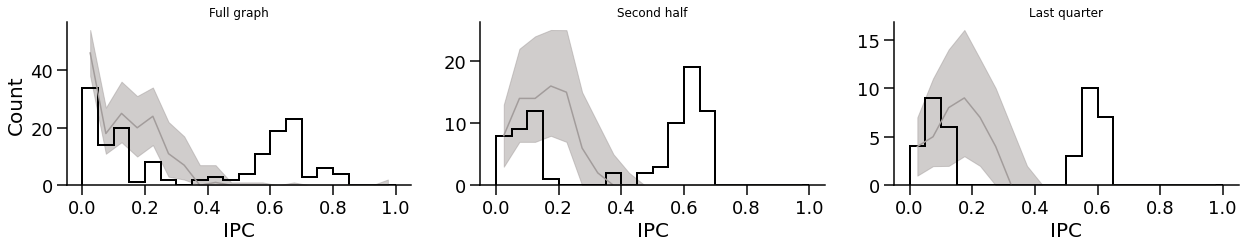

In [ ]:
plt.figure(figsize=(21, 3), facecolor="white")

numblocks = g.vertex_properties["block"].a.max() + 1

plt.subplot(1, 3, 1)
plot_comparison(np.ones((len(g.vertex_properties["block"].a),), dtype=bool))
plt.title("Full graph")

plt.subplot(1, 3, 2)
plot_comparison(g.vertex_properties["block"].a >= numblocks / 2)
plt.title("Second half")
plt.ylabel("")

plt.subplot(1, 3, 3)
plot_comparison(g.vertex_properties["block"].a >= numblocks * 3 / 4)
plt.title("Last quarter")
plt.ylabel("")

plt.show()

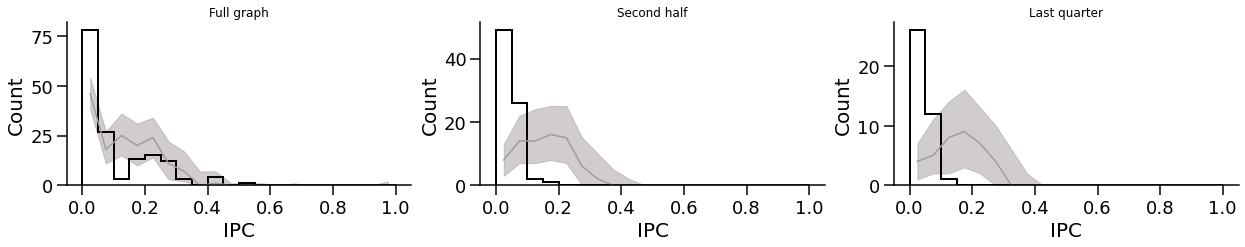

In [71]:
plt.figure(figsize=(21, 3), facecolor="white")

numblocks = g.vertex_properties["block"].a.max() + 1

plt.subplot(1, 3, 1)
plot_comparison(np.ones((len(g.vertex_properties["block"].a),), dtype=bool), orig_ipcs_od)
plt.title("Full graph")

plt.subplot(1, 3, 2)
plot_comparison(g.vertex_properties["block"].a >= numblocks / 2, orig_ipcs_od)
plt.title("Second half")

plt.subplot(1, 3, 3)
plot_comparison(g.vertex_properties["block"].a >= numblocks * 3 / 4, orig_ipcs_od)
plt.title("Last quarter")

plt.show()